In [10]:
from google.colab import auth
auth.authenticate_user()

In [11]:
!pip3 install transformers emoji==0.6.0 keras_nlp

In [12]:
!rm -r cil-sentiment/
!git clone https://github.com/carlosinator/cil-sentiment.git

Cloning into 'cil-sentiment'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 301 (delta 107), reused 149 (delta 92), pack-reused 128
Receiving objects: 100% (301/301), 2.43 MiB | 15.77 MiB/s, done.
Resolving deltas: 100% (163/163), done.


In [13]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras_nlp
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
import transformers
from transformers import AutoTokenizer, TFAutoModel, AutoConfig, TFAutoModelForSequenceClassification
import matplotlib.pyplot as plt
import pickle
import sys
sys.path.append("./cil-sentiment/")
sys.path.append("./")
from experiments import *

# Define experiments

In [14]:
BATCH_SIZE = 256

EXPERIMENTS = [
  Experiment(model_type='base',     hidden_dimension=0,   learning_rate=2e-5, epochs=5, batchsize=BATCH_SIZE),
  Experiment(model_type='read',     hidden_dimension=8,   learning_rate=1e-3, epochs=5, batchsize=BATCH_SIZE),
  Experiment(model_type='read',     hidden_dimension=64,  learning_rate=1e-3, epochs=5, batchsize=BATCH_SIZE),
  Experiment(model_type='read',     hidden_dimension=256, learning_rate=1e-3, epochs=5, batchsize=BATCH_SIZE),
  Experiment(model_type='read_gru', hidden_dimension=8,   learning_rate=1e-3, epochs=5, batchsize=BATCH_SIZE),
  Experiment(model_type='read_gru', hidden_dimension=64,  learning_rate=1e-3, epochs=5, batchsize=BATCH_SIZE),
  Experiment(model_type='read_gru', hidden_dimension=256, learning_rate=1e-3, epochs=5, batchsize=BATCH_SIZE),
  Experiment(model_type='minion',   hidden_dimension=8,   learning_rate=1e-3, epochs=5, batchsize=BATCH_SIZE),
  Experiment(model_type='minion',   hidden_dimension=64,  learning_rate=1e-3, epochs=5, batchsize=BATCH_SIZE),
  Experiment(model_type='minion',   hidden_dimension=64,  learning_rate=3e-4, epochs=5, batchsize=BATCH_SIZE),
  Experiment(model_type='minion',   hidden_dimension=256, learning_rate=1e-3, epochs=5, batchsize=BATCH_SIZE),
]


# Run experiments

In [15]:
# reproducibility
transformers.set_seed(0) # sets the seed in random, numpy, and tf

In [16]:
!gsutil cp "gs://cil_2023/train_pos_full_preprocessed_without_duplicates.txt" .
!gsutil cp "gs://cil_2023/train_neg_full_preprocessed_without_duplicates.txt" .

filename_train_pos = "train_pos_full_preprocessed_without_duplicates.txt"
filename_train_neg = "train_neg_full_preprocessed_without_duplicates.txt"
base_model_name = "vinai/bertweet-base"

Copying gs://cil_2023/train_pos_full_preprocessed_without_duplicates.txt...
/ [1 files][ 74.6 MiB/ 74.6 MiB]                                                
Operation completed over 1 objects/74.6 MiB.                                     
Copying gs://cil_2023/train_neg_full_preprocessed_without_duplicates.txt...
| [1 files][ 91.6 MiB/ 91.6 MiB]   11.3 MiB/s                                   
Operation completed over 1 objects/91.6 MiB.                                     


In [8]:
# read dataset
dataset_pos_pd = pd.read_table(filename_train_pos, sep='\r\n', header=None, names=['text'])
dataset_neg_pd = pd.read_table(filename_train_neg, sep='\r\n', header=None, names=['text'])
dataset_pos_pd['label'] = 0
dataset_neg_pd['label'] = 1
dataset_pd = pd.concat([dataset_pos_pd, dataset_neg_pd])

# shuffle
dataset_pd = dataset_pd.sample(frac=1, random_state=0).reset_index(drop=True)

# tokenize data set
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
texts = tokenizer.batch_encode_plus(dataset_pd['text'].tolist(),
                                    padding=True, truncation=True,
                                    return_tensors='tf')

dataset = tf.data.Dataset.from_tensor_slices((dict(texts), dataset_pd['label']))

# split data set into training, validation, test
AUTOTUNE = tf.data.experimental.AUTOTUNE

val_data_size = test_data_size = int(0.1 * len(dataset_pd.index))
train_data_size = len(dataset_pd.index) - val_data_size - test_data_size

train_ds = dataset.take(train_data_size).batch(BATCH_SIZE, drop_remainder=True)
val_ds = dataset.skip(train_data_size).take(val_data_size).batch(BATCH_SIZE, drop_remainder=True)
test_ds = dataset.skip(train_data_size).skip(val_data_size).batch(BATCH_SIZE, drop_remainder=True)

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

<ipython-input-8-911509fe6a14>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset_pos_pd = pd.read_table(filename_train_pos, sep='\r\n', header=None, names=['text'])
<ipython-input-8-911509fe6a14>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset_neg_pd = pd.read_table(filename_train_neg, sep='\r\n', header=None, names=['text'])


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
# training
for e in EXPERIMENTS:
  e.compile()
  e.train(train_ds, val_ds)

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/5
7095/7095 [==============================] - 1044s 145ms/step - loss: 0.2931 - sparse_categorical_accuracy: 0.8736 - val_loss: 0.2682 - val_sparse_categorical_accuracy: 0.8862
Epoch 2/5
7095/7095 [==============================] - 1028s 145ms/step - loss: 0.2776 - sparse_categorical_accuracy: 0.8810 - val_loss: 0.2640 - val_sparse_categorical_accuracy: 0.8869
Epoch 3/5
7095/7095 [==============================] - 1028s 145ms/step - loss: 0.2742 - sparse_categorical_accuracy: 0.8825 - val_loss: 0.2611 - val_sparse_categorical_accuracy: 0.8889
Epoch 4/5
7095/7095 [==============================] - 1029s 145ms/step - loss: 0.2720 - sparse_categorical_accuracy: 0.8835 - val_loss: 0.2592 - val_sparse_categorical_accuracy: 0.8897
Epoch 5/5
7095/7095 [==============================] - 1029s 145ms/step - loss: 0.2712 - sparse_categorical_accuracy: 0.8841 - val_loss: 0.2603 - val_sparse_categorical_accuracy: 0.8905


/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model 

Epoch 1/5
7095/7095 [==============================] - 2121s 278ms/step - loss: 0.2821 - sparse_categorical_accuracy: 0.8785 - val_loss: 0.2536 - val_sparse_categorical_accuracy: 0.8919
Epoch 2/5
7095/7095 [==============================] - 1935s 273ms/step - loss: 0.2585 - sparse_categorical_accuracy: 0.8897 - val_loss: 0.2467 - val_sparse_categorical_accuracy: 0.8961
Epoch 3/5
7095/7095 [==============================] - 1932s 272ms/step - loss: 0.2480 - sparse_categorical_accuracy: 0.8946 - val_loss: 0.2433 - val_sparse_categorical_accuracy: 0.8978
Epoch 4/5
7095/7095 [==============================] - 1933s 272ms/step - loss: 0.2397 - sparse_categorical_accuracy: 0.8985 - val_loss: 0.2426 - val_sparse_categorical_accuracy: 0.8977
Epoch 5/5
7095/7095 [==============================] - 1933s 272ms/step - loss: 0.2330 - sparse_categorical_accuracy: 0.9017 - val_loss: 0.2464 - val_sparse_categorical_accuracy: 0.8965


/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model 

Epoch 1/5
7095/7095 [==============================] - 1923s 266ms/step - loss: 0.2765 - sparse_categorical_accuracy: 0.8810 - val_loss: 0.2560 - val_sparse_categorical_accuracy: 0.8948
Epoch 2/5
7095/7095 [==============================] - 1880s 265ms/step - loss: 0.2568 - sparse_categorical_accuracy: 0.8906 - val_loss: 0.2457 - val_sparse_categorical_accuracy: 0.8958
Epoch 3/5
7095/7095 [==============================] - 1881s 265ms/step - loss: 0.2558 - sparse_categorical_accuracy: 0.8910 - val_loss: 0.2465 - val_sparse_categorical_accuracy: 0.8967
Epoch 4/5
7095/7095 [==============================] - 1881s 265ms/step - loss: 0.2547 - sparse_categorical_accuracy: 0.8917 - val_loss: 0.2460 - val_sparse_categorical_accuracy: 0.8958
Epoch 5/5
7095/7095 [==============================] - 1880s 265ms/step - loss: 0.2548 - sparse_categorical_accuracy: 0.8915 - val_loss: 0.2493 - val_sparse_categorical_accuracy: 0.8944


/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [17]:
# loading already trained & saved models
for e in EXPERIMENTS:
  e.load_model()

In [18]:
# evaluation
scorings = []
for e in EXPERIMENTS:
  scorings.append(e.evaluate(test_ds))

# save scorings
with open("scorings.pkl", 'wb') as f:
  pickle.dump(scorings, f)
!gsutil mv ./scorings.pkl gs://cil_2023/final_models/

886/886 [==============================] - 144s 155ms/step


In [39]:
# load scorings
!gsutil cp gs://cil_2023/final_models/scorings.pkl .
with open("scorings.pkl", 'rb') as f:
  scorings = pickle.load(f)

Copying gs://cil_2023/final_models/scorings.pkl...
- [1 files][  5.2 KiB/  5.2 KiB]                                                
Operation completed over 1 objects/5.2 KiB.                                      


# Results

In [40]:
# Initialize lists for each column
df = pd.DataFrame(columns=[
    'model type', 'learning rate', 'hidden dimension', 'batch size', 'epochs', 'trainable parameters', 'trainable parameters (%)',
    'total parameters', 'accuracy', 'f1-score', 'ACE', 'MCE', 'training duration (min)', 'average time per epoch (min)',
    'energy consumption (kWh)', 'power (kW)'
])

# fill table
for i, e in enumerate(EXPERIMENTS):
  df.loc[i] = [''] * len(df.columns)

  df.loc[i]['model type'] = e.model_type
  df.loc[i]['learning rate'] = '{:.1e}'.format(e.learning_rate)
  df.loc[i]['hidden dimension'] = e.hidden_dimension if not e.model_type == 'base' else 0
  df.loc[i]['batch size'] = e.batchsize
  df.loc[i]['epochs'] = e.epochs
  num_trainable_params = np.sum([tf.size(v) for v in e.model.trainable_variables])
  num_tot_params = e.model.count_params()
  df.loc[i]['trainable parameters'] = '{:,}'.format(num_trainable_params)
  df.loc[i]['trainable parameters (%)'] = '{:.2f}%'.format(100 * num_trainable_params / num_tot_params)
  df.loc[i]['total parameters'] = '{:,}'.format(num_tot_params)
  df.loc[i]['accuracy'] = '{:.4f}'.format(scorings[i]['accuracy'])
  df.loc[i]['f1-score'] = '{:.4f}'.format(scorings[i]['f1'])
  df.loc[i]['ACE'] = '{:.4f}'.format(scorings[i]['ace'])
  df.loc[i]['MCE'] = '{:.4f}'.format(scorings[i]['mce'])
  duration_sec, _, _, average_time_per_epoch_sec = e.get_duration()
  df.loc[i]['training duration (min)'] = '{:.2f}'.format(duration_sec / 60)
  df.loc[i]['average time per epoch (min)'] = '{:.2f}'.format(average_time_per_epoch_sec / 60)
  energy = e.compute_energy_consumption()
  df.loc[i]['energy consumption (kWh)'] = '{:.2f}'.format(energy)
  df.loc[i]['power (kW)'] = '{:.2f}'.format(energy / (duration_sec / 3600))

df

,model type,learning rate,hidden dimension,batch size,epochs,trainable parameters,trainable parameters (%),total parameters,accuracy,f1-score,ACE,MCE,training duration (min),average time per epoch (min),energy consumption (kWh),power (kW)
0,base,2.0e-05,0,256,5,"134,901,506",100.00%,"134,901,506",0.9042,0.9042,0.0474,0.1311,214.00,42.80,1.39,0.39
1,read,1.0e-03,8,256,5,"14,674",0.01%,"134,914,642",0.8864,0.8864,0.0190,0.0522,82.83,16.57,0.52,0.38
2,read,1.0e-03,64,256,5,"104,834",0.08%,"135,004,802",0.8911,0.8911,0.0228,0.0712,83.17,16.63,0.53,0.38
3,read,1.0e-03,256,256,5,"461,570",0.34%,"135,361,538",0.8920,0.8920,0.0168,0.0547,86.00,17.20,0.55,0.38
4,read_gru,1.0e-03,8,256,5,"45,794",0.03%,"134,945,762",0.8938,0.8938,0.0250,0.0733,147.17,29.43,0.80,0.33
5,read_gru,1.0e-03,64,256,5,"371,714",0.27%,"135,271,682",0.8971,0.8970,0.0312,0.0947,148.50,29.70,0.85,0.34
6,read_gru,1.0e-03,256,256,5,"1,774,850",1.30%,"136,674,818",0.8979,0.8978,0.0273,0.0952,164.33,32.87,0.99,0.36
7,minion,1.0e-03,8,256,5,"28,146",0.02%,"134,928,114",0.8969,0.8969,0.0036,0.0391,115.67,23.13,0.72,0.37
8,minion,1.0e-03,64,256,5,"273,538",0.20%,"135,173,506",0.8994,0.8994,0.0151,0.0774,126.67,25.33,0.79,0.37
9,minion,3.0e-04,64,256,5,"273,538",0.20%,"135,173,506",0.9015,0.9015,0.0048,0.0235,128.33,25.67,0.79,0.37


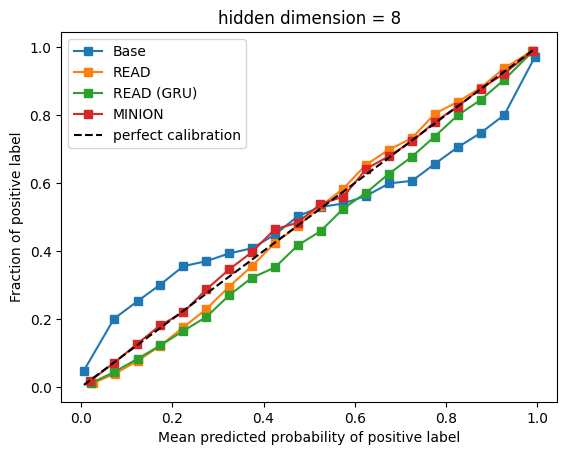

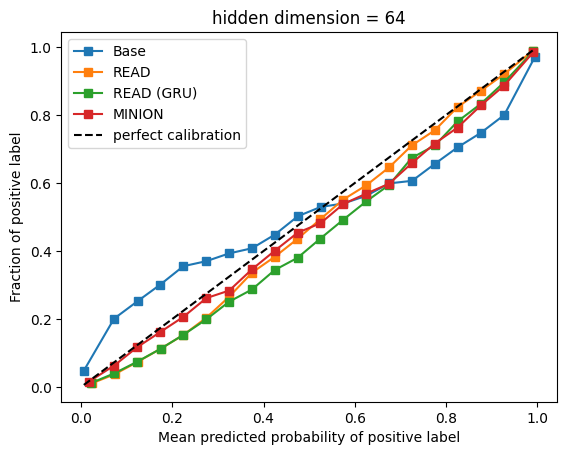

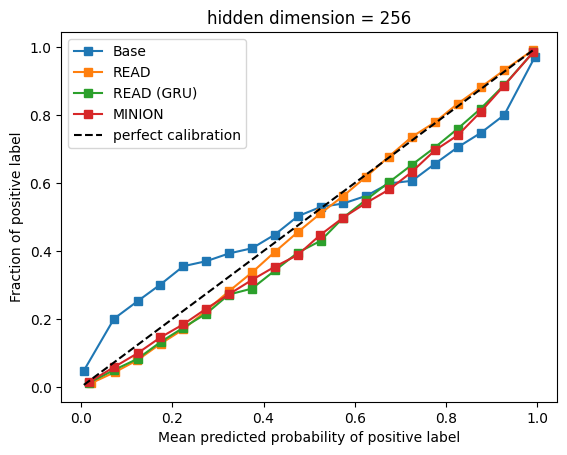

In [41]:
# draw calibration plots
cal_data = [{"model_type" : e.model_type, "hidden_dimension" : e.hidden_dimension,
             "x" : s["cal_curve_x"], "y" : s["cal_curve_y"]}\
            for e, s in zip(EXPERIMENTS, scorings) if e.learning_rate == 1e-3 or e.model_type == 'base']

cal_data_base = [e for e in cal_data if e["model_type"] == 'base']

type_to_name = {'base' : 'Base', 'read' : 'READ', 'read_gru' : 'READ (GRU)', 'minion' : 'MINION'}
for hd in [8, 64, 256]:
  exps = cal_data_base + [e for e in cal_data if e["hidden_dimension"] == hd]
  for e in exps:
    plt.plot(e["x"], e["y"], label=type_to_name[e["model_type"]], marker='s')
  plt.plot(exps[0]["x"], exps[0]["x"], label="perfect calibration", linestyle='--', color='black')
  plt.xlabel("Mean predicted probability of positive label")
  plt.ylabel("Fraction of positive label")
  plt.title("hidden dimension = {}".format(hd))
  plt.legend()
  plt.show()
